### Protein Composition Statistics

The analysis functions are located in `./indels/proteins.py`, which draws general functions from `./indels/ind.py`

In [1]:
# Perform the initialization and imports
import sys
import pickle
import re
import os
import csv
import argparse
import math
import pprint

from string import ascii_lowercase
from collections import Counter, defaultdict

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from Bio import SeqIO, AlignIO
from Bio.SeqRecord import SeqRecord
from Bio.Alphabet import IUPAC
from Bio.Seq import Seq
from Bio.Emboss.Applications import NeedleallCommandline

# Demand Python 3.
if sys.version_info[0] < 3:
    print("Python 3 is required, but you are using Python %i.%i.%i") % (
        sys.version_info[0], sys.version_info[1], sys.version_info[2])
    sys.exit(1)

If the InDelScanner directory is not on your path, modify the `indels_path` variable to point to it.

In [2]:
# Retrieve the specific functions from ind and proteins.py
indels_path="/home/maya/InDelScanner"  # /PATH/TO/InDelScanner
if indels_path not in sys.path:
    sys.path.append(indels_path)
from indels.ind import trim_read, findEnds, endMatch, findGap, gapAlign

Specify the working directory: this should be where your input files are located.

In [3]:
os.chdir("/mnt/c/Users/Maya/Dropbox/mek_results")

## Experiment design
In this experiment, the peptide libraries were split by FACS into three gates: high, medium and low. This DNA was isolated by PCR and sequenced in the same Illumina run. Due to initial low covereage of the "low" gate, this fraction was re-sequenced to yield "low-v2". The next cell loads the alignment dictionaries from both sequencing runs and combines into one Counter class.
Because of re-sequencing in the low fraction, we choose to combine the counts from both sequencing runs to take advantage of the total higher coverage.

### Library composition
The peptide libraries were randomized in the form MPKKKXTPXQXNXAPDGS; the randomized X positions are 6, 9, 11 and 13. Additionally, there is a possible insertion of A at position 7a (after TP) and a potential randomized X insertion at postion 8a. X may be any one of ADFGIKLMPVWY.

In [4]:
with open('Remkes_protein.p', 'rb') as f:
    all_ref = pickle.load(f)
with open('Remkes_protein_low.p', 'rb') as f:
    low = pickle.load(f)

all_ref['mek']['low-v2'] = low['mek']['low-v2']

mek = {}
for fraction in ['high', 'med']:
    mek[fraction] = Counter(all_ref['mek'][fraction])
mek['low-t'] = Counter(all_ref['mek']['low']) + Counter(all_ref['mek']['low-v2'])

Start inspection of the dataset by looking for most enriched variants in each gate and checking their presence in the other gates. This treats the NGS dataset as a way to find the most active variants in a straighforward way - the most active variants should:
* have a strong enrichment for the top gate, with high counts in 'high' gate and low to zero counts in the 'low' gate; though there will be some bleed-over of signal due to errors during FACS
* be highly present in the 'high' gate

Output files: Top hits - FRACTION NAME.csv

In [5]:
def top_variant_distribution(mek, fraction, filename):

    top = mek[fraction].most_common(200)
    with open(filename, 'w') as f:
        csv_writer = csv.writer(f, delimiter=',')
        csv_writer.writerow(['Mutation', 'High', 'Medium', 'Low'])
        for pair in top:
            protein = pair[0]
            csv_writer.writerow([protein, mek['high'][protein], mek['med'][protein], mek['low-t'][protein]] )

top_variant_distribution(mek, 'high', 'Top hits - High.csv')
top_variant_distribution(mek, 'med', 'Top hits - Med.csv')
top_variant_distribution(mek, 'low-t', 'Top hits - Low.csv')

df_top = pd.read_csv('Top hits - High.csv')
df_top.head(15)

,Mutation,High,Medium,Low
0,6L/7aI/8aA/9L/11F/13M,1185,33,6
1,6F/7aP/9W/11L/13M,903,81,15
2,6L/7aF/9L/11I/13I,899,2,8
3,6A/7aI/8aA/9L/11L/13I,893,3,19
4,6W/7aI/9F/11L/13V,880,34,20
5,6A/7aP/8aA/9L/11V/13W,872,0,18
6,6L/7aI/8aA/9M/11W/13W,871,24,18
7,6V/7aP/8aA/9F/11F/13M,869,1,5
8,6A/7aK/9L/11L/13W,859,0,14
9,6A/7aI/8aA/9L/11V/13M,852,0,26


## Single position enrichments
The original protein before sorting is balanced: each randomized position contains an equal amount of each amino acid, as far as technically possible.

If a particular amino acid (for example, L in position 9) is adaptive for strong binding, the 'high' gate of the library should be enriched for that amino acid in that position. Hence, a deviation from balanced composition at any one position indicates that the enriched amino acids promote active binding while those depleted (and correspondingly enriched in the 'low' gate) are disruptive to binding.

In [6]:
def convert_variant_to_dict(mutation_string):
    """
    Convert a string of positions deviating from WT into a dictionary listing the status at all positions
    Input: string of the format '6A/7aK/9L' etc.
    Output: dictionary listing AA at each position, including WT
    """
    wt = {'6': 'P', '7a': 'Δ', '8a': 'Δ', '9': 'I', '11': 'L', '13': 'P'}
    
    mutation_list = mutation_string.split('/')
    m_by_pos = {point_mutation[:-1] : point_mutation[-1] for point_mutation in mutation_list}
    
    for position in wt.keys():   # need to do it this way so that WT positions are included
        try:
            m_by_pos[position]
        except KeyError:
            m_by_pos[position] = wt[position]

    return m_by_pos


def passes_restriction(m_by_pos, restrict):
    """
    Helper function in case we are looking at enrichment with certain positions fixed. 'restrict' is a dictionary of the form
    restrict[position] = ['A', 'L'] etc.
    """
    wt = {'6': 'P', '7a': 'Δ', '8a': 'Δ', '9': 'I', '11': 'L', '13': 'P'}
    
    if restrict:
        for position, allowed_aa in restrict.items():
            try:
                aa = m_by_pos[position]
            except KeyError:
                aa = wt[position]
            
            if aa not in allowed_aa:
                return False

    return True


def single_fraction_enrichment(mek, fraction, cutoff, restrict = False):
    """
    Input: the dictionary containing a Counter for each fraction
    Output: dictionary with data aggregated by position, format: point_distrubution[pos][aa] = int
    """
    valid_aa = {'A', 'D', 'F', 'G', 'I', 'K', 'L', 'M', 'P', 'V', 'W', 'Y', 'Δ'}
    point_distribution = {pos: {aa: 0 for aa in valid_aa} for pos in ['6', '7a', '8a', '9', '11', '13']}
    wt = {'6': 'P', '7a': 'Δ', '8a': 'Δ', '9': 'I', '11': 'L', '13': 'P'}

    # the input data is formatted as mek['fraction'][mutation_string] = integer
    # each mutation is a collection of mutations of the format Integer + single letterAA code, separated by '/'
    # we are querying this by position, so need to split by position and convert into a new Counter:
    # mek['fraction']['position']['amino_acid'] = integer
    
    for mutation_string, count in mek[fraction].items():
        if count > cutoff:  # ignore the frameshifts and such coming from noise
            
            # m_by_pos[position] = AA
            m_by_pos = convert_variant_to_dict(mutation_string)
            # check the mutations is one we're interested in
            observed_aa = set(m_by_pos.values())
            if not observed_aa.issubset(valid_aa):
                continue
            
            # in case we are considering relative enrichement, where some position is fixed:
            # the constrains has the form of a dictionary with allowed amino acids in tha tposition
            if not passes_restriction(m_by_pos, restrict):
                continue                

            # for the valid AAs, add counts to position proportions
            for pos, aa in m_by_pos.items():  # need to do it this way so that WT positions are included
                point_distribution[pos][aa] += count
    
    return point_distribution

In [7]:
def make_composition_plot_per_position(df_point, title_text, filename):
    sns.set_palette("tab20", 13)
    cols = df_point.columns.values.tolist()  
    aa_all = df_point.index.values.tolist()  # have the same labels and colorscheme for all charts

    fig = plt.figure(figsize=(13,2.5))
    fig.suptitle(title_text)

    axes = list(range(len(cols)))  # make axes with a column for each position

    for i in range(len(cols)):
        axes[i] = fig.add_subplot(1, len(cols), i + 1)
        plt.pie(df_point[cols[i]], startangle=90)
        axes[i].set_title(cols[i])

    markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in sns.color_palette("tab20")]
    fig.legend(markers, aa_all, numpoints=1, loc='center left', ncol=2)
    fig.patch.set_facecolor('white')
    
    plt.savefig(filename + '.svg')

    plt.show()

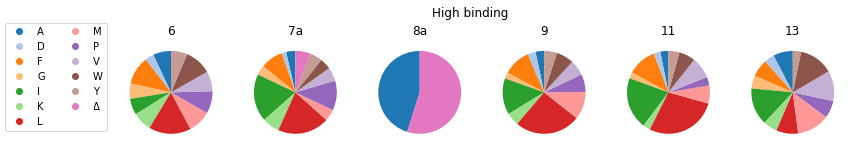

In [8]:
# Now use the distribution in this fraction to make plots
single_enrichment_high = single_fraction_enrichment(mek, 'high', 10)
df_point_high = pd.DataFrame.from_dict(single_enrichment_high)
make_composition_plot_per_position(df_point_high, 'High binding', 'High_no_filter')

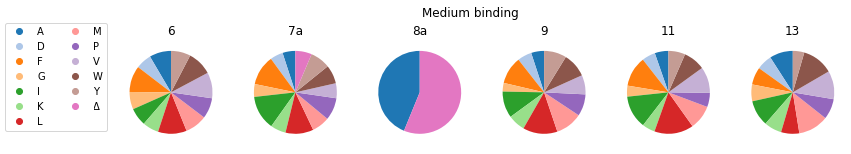

In [9]:
med = single_fraction_enrichment(mek, 'med', 3)
df_point = pd.DataFrame.from_dict(med)
make_composition_plot_per_position(df_point, 'Medium binding', 'Medium_no_filter')

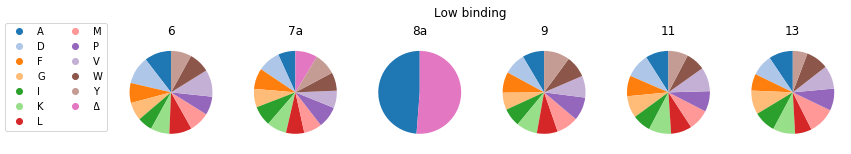

In [10]:
low = single_fraction_enrichment(mek, 'low-t', 3)
df_point = pd.DataFrame.from_dict(low)
make_composition_plot_per_position(df_point, 'Low binding', 'Low_no_filter')

### Shannon Entropy (SE) at single positions
We often ask "How conserved is a position in an amino acid alignment?" Shannon entropy is a concept coming from information theory that gives a numerical description of conservation, with range from 0 (completely conserved) and 1 (no conservation). While the use of SE in protein sciece derives from analysis of protein sequence alignments, we can adapt SE for analysis of conservation in these sorted libraries by constructing "virtual multiple sequence alignment": each detected variant that has a count X above the cutoff is counted X-times, to weigh the amino acid distribution per position according to how frequent variants are. Therefore, the most strongly enriched variants also have the strongest effect on SE.

#### SE definitions
Single position Shannon entropy is defined as $$S_i = - \sum_{a=1}^{N} f_a \cdot log_N(f_a)$$
Frequency of amino acids: $$f_a = \frac{p + c_a}{n + 1}$$where $c_a$ is the number of amino acids $a$ at that position, $n$ is the total number of sequences and $p = \frac{1}{N}$ for alphabet of size $N$; here $N$ equals 2 (position 8a), 12 (positions 6, 9, 11 and 13) or 13 (positon 7a). 

#### Expectation: low conservation
In the graphs above we see that there is a shift in the distribution between the low, medium and high gates, but no amino acid dominates the outcome in the high gate. Hence, we expect that the conservation in terms of SE will be close to 1.

In [11]:
def Shannon_par(point_distribution, position):
    """
    Helper function to calculate Shannon pseudo-count
    :param point_distribution: calculated by single_fraction_enrichment
    :param position:
    :return:
    """
    N = 0  # size of amino acid alphabet
    n = 0  # total number of observed variants
    for aa, count in point_distribution[position].items():
        if count > 0:
            N += 1
            n += count

    p = 1/N

    return {'p': p, 'N': N, 'n': n}


def position_entropy(point_distribution, position):
    """
    Shannon entropy of a single position in protein alignment.
    :param point_distribution: calculated by single_fraction_enrichment
    :param position:
    :return:
    """
    # point_proportions has the structure point_proportions[pos][aa] = count
    S_i = 0
    par = Shannon_par(point_distribution, position)

    for aa, count in point_distribution[position].items():
        if count == 0:
            continue
        else:
            f_a = (par['p'] + count) / (par['n'] + 1)
            S_i -= f_a * math.log(f_a, par['N'])

    return S_i


In [12]:
shannon_entropy_single = {}
for position in single_enrichment_high.keys():
    shannon_entropy_single[position] = position_entropy(single_enrichment_high, position)
pd.DataFrame.from_dict(shannon_entropy_single, orient='index', columns=['Shannon Entropy'])

,Shannon Entropy
6,0.973233
7a,0.913550
8a,0.993028
9,0.907801
11,0.861150
13,0.960111


Above, we see that all single position Shannon entropies are >0.85, where 1 is complete absence of conservation, indicating that there is little conservation in any position. As such, there isn't a single amino acid at any position that dominates the signal.

### Relative enrichment at other positions when some have a specific amino acid

The peptides in MEK1 and MEK2 both fit into the same binding groove on the downstram kinase ERK1/2

MEK1 has the WT peptide with 6P, 7aΔ, 8aΔ, 9I, 11L and 13P.

MEK2 has 6P, 7aL, 8aA, 9L, 11I and 13P.

Hypothesised effects are:
* the switching of residues between 9I/11L and 9L/11I
* the insertions at 7a and 8a are characteristic of MEK2

The profile 9L/11L is a step towards a promiscuous peptide that binds both ERK1/2 and JNK - the latter has an expected profile 9L/11L with either F, I or L at position 13. So, does selecting for 9L/11L when testing ERK binding select for generalist binders that show the same enrichment at position 13?
What are the single site preferences at the other positions: 6, 7a, a and 13?

       6     7a      8a       9      11     13
A  28491  16417  148043       0       0  18970
D  17089   6524       0       0       0  14485
F  29022  26991       0       0       0  17150
G  21920  15169       0       0       0  12082
I  17545  34801       0       0       0  35361
K  24248  22626       0       0       0  19075
L  28742  27814       0  284667  284667  29365
M  22637  20553       0       0       0  37606
P  19740  34781       0       0       0  24264
V  26633  19878       0       0       0  34482
W  25977  14713       0       0       0  30707
Y  22623  22213       0       0       0  11120
Δ      0  22187  136624       0       0      0



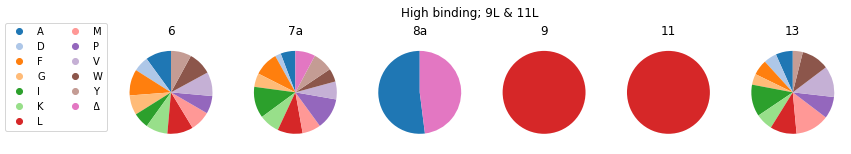

In [18]:
restrict = {'9':['L'], '11':['L']}
# Now use the distribution in this fraction to make plots
high_r = single_fraction_enrichment(mek, 'high', 10, restrict)
df_point = pd.DataFrame.from_dict(high_r)
print(df_point)
print()
make_composition_plot_per_position(df_point, 'High binding; 9L & 11L', 'High_9L_11L')

It appears the enrichment at 13 is no different than the overall profile in the high gate.

When position 9=I, and 11=L, what are the single site preferences at the 
other positions: 6, 7a, 8a and 13

       6     7a     8a       9      11     13
A  14328   6916  76977       0       0  12211
D   6735   1887      0       0       0   6209
F  17199  12044      0       0       0  10047
G  10493   6794      0       0       0   9417
I   8355  21735      0  152815       0  24038
K  14559  13765      0       0       0   7689
L  16939  18655      0       0  152815  14659
M   9564   9322      0       0       0  18157
P  11137  22584      0       0       0   8648
V  15947  11970      0       0       0  16328
W  15776   5427      0       0       0  19844
Y  11783   9797      0       0       0   5568
Δ      0  11919  75838       0       0      0



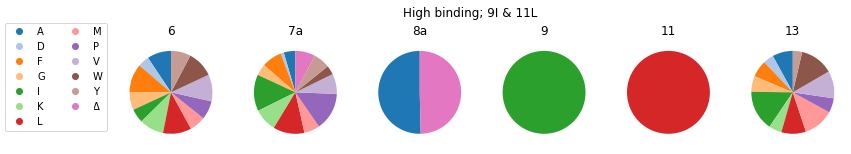

In [19]:
restrict = {'9':['I'], '11':['L']}
# Now use the distribution in this fraction to make plots
high_r = single_fraction_enrichment(mek, 'high', 10, restrict)
df_point = pd.DataFrame.from_dict(high_r)
print(df_point)
print()
make_composition_plot_per_position(df_point, 'High binding; 9I & 11L', 'High_9I_11L')

When position 9=L, and 11=I, what are the single site preferences at the 
other positions: 6, 7a, 8a and 13

       6     7a      8a       9      11     13
A  26809  15084  141753       0       0  22894
D  16665   6173       0       0       0   9865
F  26103  24317       0       0       0  16018
G  21144  15573       0       0       0  13702
I  13787  33156       0       0  252926  28191
K  21619  18670       0       0       0  17593
L  26506  26195       0  252926       0  19634
M  19086  16745       0       0       0  33147
P  19228  27024       0       0       0  23208
V  21186  16210       0       0       0  34335
W  21421  12130       0       0       0  26424
Y  19372  22083       0       0       0   7915
Δ      0  19566  111173       0       0      0



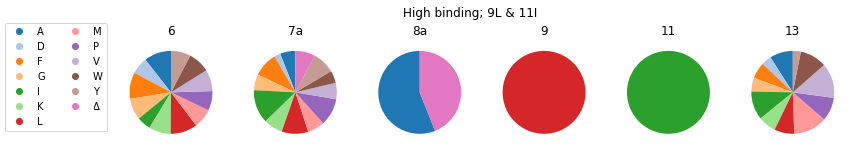

In [20]:
restrict = {'9':['L'], '11':['I']}
# Now use the distribution in this fraction to make plots
high_r = single_fraction_enrichment(mek, 'high', 10, restrict)
df_point = pd.DataFrame.from_dict(high_r)
print(df_point)
print()
make_composition_plot_per_position(df_point, 'High binding; 9L & 11I', 'High_9L_11I')

When position 7a=insertion (any), and 8a=A, what are the single site 
preferences at position 9 and 11

        6      7a       8a       9      11      13
A  150365   60091  1961685   36022   63339  173494
D   79122   39239        0   27469   50483   91553
F  211405  197125        0  271645  258554  125849
G  124967  108016        0    5150   40909  110691
I  124372  439061        0  329568  375166  232509
K  158734   83357        0   52178   58618  132676
L  291917  346367        0  649325  450250  141008
M  164530   77772        0  231654  160067  248912
P  168791  356287        0   77512   68068  149019
V  147190   84855        0   52689  191945  233342
W  196616   61769        0  127908  141968  256387
Y  143676  107746        0  100565  102318   66245
Δ       0       0        0       0       0       0



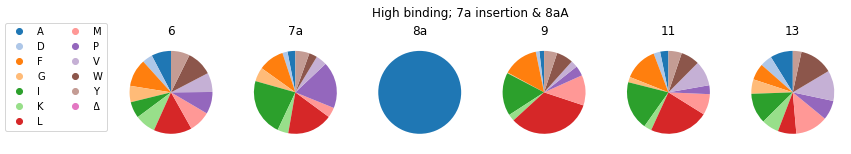

In [21]:
restrict = {'7a':['A', 'D', 'F', 'G', 'I', 'K', 'L', 'M', 'P', 'V', 'W', 'Y'], '8a':['A']}
# Now use the distribution in this fraction to make plots
high_r = single_fraction_enrichment(mek, 'high', 10, restrict)
df_point = pd.DataFrame.from_dict(high_r)
print(df_point)
print()
make_composition_plot_per_position(df_point, 'High binding; 7a insertion & 8aA', 'High_7aX_8aA')

When position 7.5=del, and 8a=del, what are the single site preferences 
at position 9 and 11

       6      7a      8a      9     11     13
A  14801       0       0   8249   2678  11513
D   7793       0       0   7150   1260   4309
F  14902       0       0  15352  19537  15723
G   9612       0       0   5461   1898   4263
I  14564       0       0  28479  46914  32589
K  11642       0       0  12550   2470   8074
L  19173       0       0  43146  68922  22297
M  11602       0       0  13828  12984  23267
P  29210       0       0  20340   2517   9448
V  24617       0       0  14629  10491  20586
W  15550       0       0   8519   8780  27369
Y  11125       0       0   6888   6140   5153
Δ      0  184591  184591      0      0      0



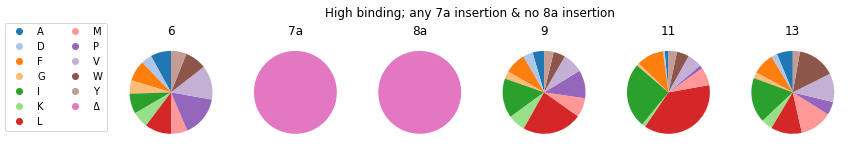

In [22]:
restrict = {'7a':['Δ'], '8a':['Δ']}
# Now use the distribution in this fraction to make plots
high_r = single_fraction_enrichment(mek, 'high', 10, restrict)
df_point = pd.DataFrame.from_dict(high_r)
print(df_point)
print()
make_composition_plot_per_position(df_point, 'High binding; any 7a insertion & no 8a insertion', 'High_7aX_8aNone')

## Quantifying conservation

So far we have treated mutations at each randomized position independently, under the model that the effect mutations at different position will be exactly additive. The alternative scenario is one where mutations are not additive, dubbed epistasis.

#### Hypothesis: little epistasis
Here we are investigating the effect of mutations on binding of MAPKKK on the target peptide on MEK-1; since this is a short peptide where each amino acid binds a different spot in the binding groove, the expectation is that the positions are largely independent and there is little overall epistasis. There may be some epistasis coming from the presence or absence of insertions at positions 7a and 8a, since they will affect the positioning of the rest of the peptide.

### Shannon Entropy and Mutual Information
Mutual information (M) between two positions ($i$ and $j$) is a commonly accepted method of quantifying epistasis between positions as a whole, and is defined as the difference between the Shannon entropy of individual positions and their joint entropy:

Mutual information: $M = S_i + S_j - 2S_{ij}$

The joint SE is defined analogously to single position entropy:
$$S_{ij} = -\sum_{a=1}^{N} \sum_{b=1}^{N}   f_{ab} \cdot log_{N_a N_b}{f_{ab}}$$
That is, the logarithm of $f_{ab}$ is taken with base $N_a N_b$.

The joint amino acid frequency is defined as $$f_{ab} = \frac{p + c_{ab}}{n + 1}$$
where $c_{ab}$ is the count of sequences with amino acids $a$, $b$ in the positions of interest. Similarly to single position, $p = \frac{1}{N_a N_b}$, where $N_a$ and $N_b$ refer to the number of sequences containing amino acids $a$ and $b$ respectively.

#### Interpretation
* Fully conserved position: **0**
* No preference for amino acid: **1**

In [18]:
def overall_covariation(mek, fraction, cutoff, restrict = False):
    """
    Input: mek['fraction']['variant'] = count
    """
    valid_aa = {'A', 'D', 'F', 'G', 'I', 'K', 'L', 'M', 'P', 'V', 'W', 'Y', 'Δ'}
    wt = {'6': 'P', '7a': 'Δ', '8a': 'Δ', '9': 'I', '11': 'L', '13': 'P'}
    positions = wt.keys()

    covariation = {pos_a: {aa: {pos_b: {aa: 0 for aa in valid_aa}
                                for pos_b in wt.keys()} for aa in valid_aa} for pos_a in wt.keys()}
    
    for mutation_string, count in mek[fraction].items():
        if count > cutoff:  # ignore the frameshifts and such coming from noise
            
            # m_by_pos[position] = AA
            m_by_pos = convert_variant_to_dict(mutation_string)
            
            # Check that the variant is one of the expected mutations and not noise
            observed_aa = set(m_by_pos.values())
            if not observed_aa.issubset(valid_aa):
                continue
            
            # in case we are considering relative enrichement, where some position is fixed:
            # the constrains has the form of a dictionary with allowed amino acids in tha tposition
            if not passes_restriction(m_by_pos, restrict):
                continue                

            # for the valid AAs, add counts to position proportions
            for pos_a in wt.keys():
                for pos_b in wt.keys():
                    covariation[pos_a][m_by_pos[pos_a]][pos_b][m_by_pos[pos_b]] += count

    return covariation


def export_covariation_csv(mek, fraction, cutoff):
    """
    Summarize single position preferences and export it into a CSV file.
    :param background: 'mek'
    :param frac: high, med or low
    :param cutoff: depends on the gate
    :return:
    """

    with open('.'.join(('Covariation', fraction, 'csv')), 'w') as f:
        covar = overall_covariation(mek, fraction, cutoff)

        columns = ('Position_A', 'AA_A','Position_B', 'Δ', 'A', 'D', 'F', 'G', 'I', 'K', 'L', 'M', 'P', 'V', 'W', 'Y')
        positions = ['6', '7a', '8a', '9', '11', '13']
        frac_writer = csv.DictWriter(f, delimiter=',', fieldnames=columns)
        frac_writer.writeheader()

        for pos_A in covar.keys():
            for aa_A in covar[pos_A].keys():
                for pos_B in covar[pos_A][aa_A].keys():
                    head = {'Position_A': pos_A, 'AA_A': aa_A, 'Position_B': pos_B}
                    frac_writer.writerow({**head, **covar[pos_A][aa_A][pos_B]})

    return

In [19]:
def joint_entropy(point_distribution, covar, pos_a, pos_b):
    """
    Joint entropy between two positions in a multiple sequence alignmnet.
    :param point_distribution: calculated by single_fraction_enrichment
    :param covar:
    :param pos_a:
    :param pos_b:
    :return:
    """
    par_a = Shannon_par(point_distribution, pos_a)
    par_b = Shannon_par(point_distribution, pos_b)
    S_ab = 0
    p = 1 / (par_a['N']*par_b['N'])

    #  covariation[pos_a][variant[pos_a]][pos_b][variant[pos_b]] = count
    for aa_a in covar[pos_a].keys():
        for aa_b, count in covar[pos_a][aa_a][pos_b].items():
            f_ab = (p + count)/(par_a['n'] + 1)
            S_ab -= f_ab * math.log(f_ab, par_a['N']*par_b['N'])

    return S_ab


def mutual_information(point_distribution, covar, pos_a, pos_b):
    """
    Calculate the mutual information between two positions as the difference in Shannon entropy between the sum of
    individual positions and their joint entropy.
    :param point_distribution: calculated by single_fraction_enrichment
    :param covar:
    :param pos_a:
    :param pos_b:
    :return:
    """
    S_a = position_entropy(point_distribution, pos_a)
    S_b = position_entropy(point_distribution, pos_b)
    S_ab = joint_entropy(point_distribution, covar, pos_a, pos_b)

    mi = S_a + S_b - (2 * S_ab)
    mi_n = mi / S_ab
    
    return [mi, mi_n]

In [21]:
# the single position enrichment was calculated earlier for the pie plots:  single_enrichment_high
covariation = overall_covariation(mek, 'high', 10)

joint_MI = {}
joint_MI_normalized = {}
for pos_a in single_enrichment_high.keys():
    joint_MI[pos_a] = {}
    joint_MI_normalized[pos_a] = {}
    for pos_b in single_enrichment_high.keys():
        mi_tmp = mutual_information(single_enrichment_high, covariation, pos_a, pos_b)
        joint_MI[pos_a][pos_b] = mi_tmp[0]
        joint_MI_normalized[pos_a][pos_b] = mi_tmp[1]

df_MI = pd.DataFrame.from_dict(joint_MI)
df_MI = df_MI.reindex(['6', '7a', '8a', '9', '11', '13'])
df_MI

,6,7a,8a,9,11,13
6,0.973231,0.024581,0.012832,0.005067,0.011535,0.003063
7a,0.024581,0.913548,0.063873,0.011040,0.020475,0.007320
8a,0.012832,0.063873,0.992806,0.081321,0.079025,0.021829
9,0.005067,0.011040,0.081321,0.907799,0.008048,0.006475
11,0.011535,0.020475,0.079025,0.008048,0.861148,0.009751
13,0.003063,0.007320,0.021829,0.006475,0.009751,0.960109


* The diagonal shows single position Shannon entropy: this is high across the board, indicating little conservation per position
* Off-diagonal terms are <0.1, showing a strong signal for epistasis
* The matrix is symmetrical, singe mutual information is between positions $i$ and $j$ should be the same as between $j$ and $i$

It is proper to normalize the MI, the simplest metods of which is to divide MI by the joint entropy as $M_{ij}' = \frac{M_{ij}}{S_{ij}} $

In [23]:
df_MI_n = pd.DataFrame.from_dict(joint_MI_normalized, orient='index')
df_MI_n = df_MI_n.reindex(['6', '7a', '8a', '9', '11', '13'])
df_MI_n

,6,7a,8a,9,11,13
6,1.999992,0.026400,0.013138,0.005402,0.012656,0.003174
7a,0.026400,1.999994,0.069325,0.012196,0.023344,0.007844
8a,0.013138,0.069325,1.999106,0.089388,0.089035,0.022605
9,0.005402,0.012196,0.089388,1.999992,0.009141,0.006957
11,0.012656,0.023344,0.089035,0.009141,1.999992,0.010765
13,0.003174,0.007844,0.022605,0.006957,0.010765,1.999992


Now the values are no longer restricted to [0,1], so the diagonal values are no longer relevant.

**Regardless of the exact values used, there does not appear to be a strong epistatic signal in this data.**